# **AI TECH INSTITUTE** · *Intermediate AI & Data Science*
### Week 01 · Notebook 04 — Exploratory Data Analysis (EDA)
**Instructor:** Amir Charkhi  |  **Goal:** Discover patterns, anomalies, and insights in real data.

> Format: systematic exploration → visualization preview → statistical insights → storytelling.


---
## EDA: The Detective Work of Data Science
Before modeling or visualization, we need to understand our data deeply.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
 
# Setup
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

print("Ready to explore! 🔍")

Ready to explore! 🔍


## 1. Load and First Look at Real Data

In [2]:
# Create a realistic e-commerce dataset
np.random.seed(42)
n_customers = 1000

# Generate customer data
customers = pd.DataFrame({
    'customer_id': range(1, n_customers + 1),
    'age': np.random.normal(35, 12, n_customers).clip(18, 70).astype(int),
    'city': np.random.choice(['Perth', 'Sydney', 'Melbourne', 'Brisbane', 'Adelaide'], 
                            n_customers, p=[0.15, 0.3, 0.25, 0.2, 0.1]),
    'member_type': np.random.choice(['Basic', 'Premium', 'VIP'], 
                                   n_customers, p=[0.6, 0.3, 0.1]),
    'signup_date': pd.date_range(end='2025-08-25', periods=n_customers).to_list()
})

# Generate order data
n_orders = 5000
orders = pd.DataFrame({
    'order_id': range(1, n_orders + 1),
    'customer_id': np.random.choice(customers['customer_id'], n_orders),
    'order_date': pd.date_range(end='2025-08-25', periods=n_orders),
    'amount': np.random.lognormal(4, 1, n_orders).clip(10, 1000),
    'items': np.random.poisson(3, n_orders).clip(1, 20),
    'category': np.random.choice(['Electronics', 'Clothing', 'Books', 'Home', 'Sports'],
                                n_orders, p=[0.25, 0.3, 0.15, 0.2, 0.1])
})

# Merge for complete dataset
df = pd.merge(orders, customers, on='customer_id')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (5000, 10)

First few rows:
   order_id  customer_id order_date  amount  items     category  age  \
0         1          825 2011-12-18   82.97      3  Electronics   29   
1         2           49 2011-12-19   17.77      1  Electronics   39   
2         3          685 2011-12-20  100.90      3         Home   20   
3         4           82 2011-12-21   22.89      1        Books   39   
4         5          834 2011-12-22   16.02      4     Clothing   25   

        city member_type signup_date  
0   Brisbane       Basic  2025-03-03  
1   Brisbane         VIP  2023-01-17  
2     Sydney       Basic  2024-10-14  
3  Melbourne     Premium  2023-02-19  
4     Sydney     Premium  2025-03-12  

Data types:
order_id                int64
customer_id             int64
order_date     datetime64[ns]
amount                float64
items                   int32
category               object
age                     int64
city                   object
member_type            object
signup_

## 2. Statistical Summary & Distribution Analysis

In [3]:
# Basic statistics
print("Numerical Summary:")
print(df.describe())

# Extended statistics
print("\nExtended Statistics for Amount:")
amount_stats = {
    'Mean': df['amount'].mean(),
    'Median': df['amount'].median(),
    'Mode': df['amount'].mode()[0] if len(df['amount'].mode()) > 0 else None,
    'Std Dev': df['amount'].std(),
    'Variance': df['amount'].var(),
    'Skewness': df['amount'].skew(),
    'Kurtosis': df['amount'].kurtosis(),
    'IQR': df['amount'].quantile(0.75) - df['amount'].quantile(0.25),
    'CV': df['amount'].std() / df['amount'].mean()  # Coefficient of variation
}

for stat, value in amount_stats.items():
    print(f"{stat:15}: {value:.2f}")

# Categorical summaries
print("\nCategorical Variables:")
for col in ['city', 'member_type', 'category']:
    print(f"\n{col}:")
    print(df[col].value_counts())

Numerical Summary:
       order_id  customer_id           order_date   amount    items      age  \
count   5000.00      5000.00                 5000  5000.00  5000.00  5000.00   
mean    2500.50       500.64  2018-10-21 12:00:00    88.90     3.05    35.31   
min        1.00         1.00  2011-12-18 00:00:00    10.00     1.00    18.00   
25%     1250.75       246.00  2015-05-20 18:00:00    27.63     2.00    27.00   
50%     2500.50       500.00  2018-10-21 12:00:00    55.22     3.00    35.00   
75%     3750.25       754.00  2022-03-24 06:00:00   107.84     4.00    42.00   
max     5000.00      1000.00  2025-08-25 00:00:00  1000.00    12.00    70.00   
std     1443.52       289.72                  NaN   106.42     1.66    11.02   

                      signup_date  
count                        5000  
mean   2024-04-12 15:19:52.320000  
min           2022-11-30 00:00:00  
25%           2023-08-02 00:00:00  
50%           2024-04-12 00:00:00  
75%           2024-12-22 00:00:00  
max     

### Exercise 1

**Exercise 1 — Distribution Detective (medium)**  
Check if order amounts follow a normal distribution using multiple methods.


C:\Users\Olivia\AppData\Local\Temp\ipykernel_16224\217620874.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


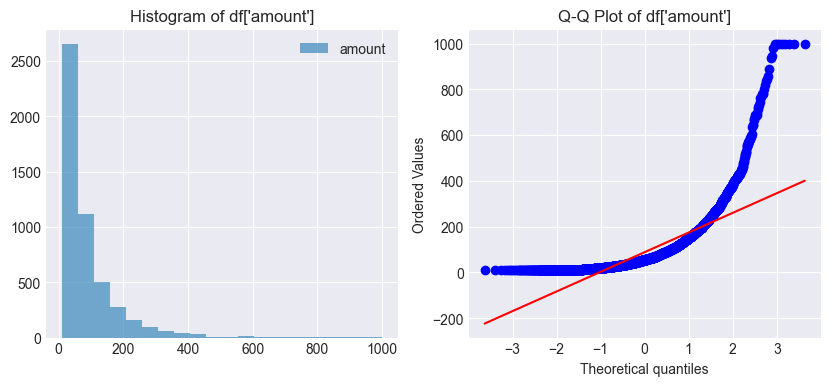

In [4]:
# Your turn
# visual method - histogram
fig, axes = plt.subplots(1,2,figsize = (10,4))

ax1 = axes[0]
x = df['amount']
ax1.hist(x, bins= 20, alpha=0.6, label='amount')
ax1.set_title("Histogram of df['amount']")
ax1.legend()

ax2 = axes[1]
x = df['amount']
stats.probplot(df['amount'], dist="norm", plot = ax2)
ax2.set_title("Q-Q Plot of df['amount']")
ax2.legend()

plt.show()

<details>
<summary><b>Solution</b></summary>

```python
# Visual check
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram
axes[0].hist(df['amount'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Order Amounts')
axes[0].set_xlabel('Amount')

# Q-Q plot
stats.probplot(df['amount'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot')

# Log-transformed
axes[2].hist(np.log(df['amount']), bins=50, edgecolor='black', alpha=0.7)
axes[2].set_title('Distribution of Log(Amount)')
axes[2].set_xlabel('Log(Amount)')

plt.tight_layout()
plt.show()

# Statistical test
statistic, p_value = stats.shapiro(df['amount'].sample(min(5000, len(df))))
print(f"Shapiro-Wilk test: statistic={statistic:.4f}, p-value={p_value:.4f}")
print(f"Normal distribution: {'Rejected' if p_value < 0.05 else 'Not rejected'}")

# Log-normal test
log_stat, log_p = stats.shapiro(np.log(df['amount']).sample(min(5000, len(df))))
print(f"\nLog-normal test: statistic={log_stat:.4f}, p-value={log_p:.4f}")
print(f"Log-normal distribution: {'Rejected' if log_p < 0.05 else 'Not rejected'}")
```
</details>

## 3. Correlation and Relationships

Correlation Matrix:
          amount     items       age
amount  1.00e+00 -2.20e-02  5.73e-03
items  -2.20e-02  1.00e+00  6.73e-04
age     5.73e-03  6.73e-04  1.00e+00


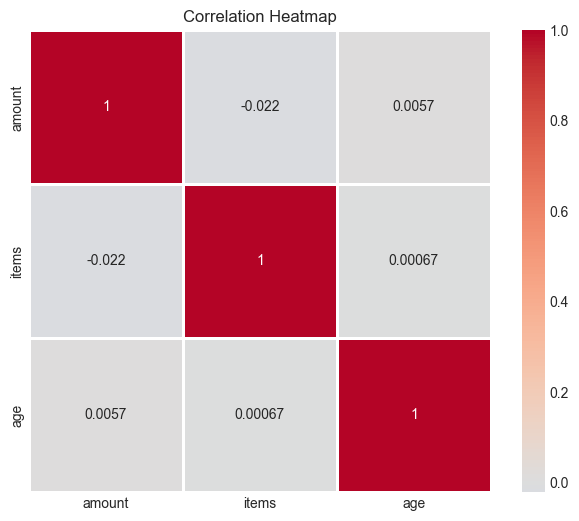


Average order amount by member type:
            amount                     
              mean median     std count
member_type                            
Basic        89.57  55.79  104.92  3034
Premium      88.92  55.40  107.36  1472
VIP          84.70  50.35  112.69   494

ANOVA test for member types: F=0.45, p=0.6406


In [5]:
# Prepare numeric features
numeric_df = df[['amount', 'items', 'age']].copy()

# Calculate correlations
corr_matrix = numeric_df.corr()
print("Correlation Matrix:")
print(corr_matrix)

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1)
plt.title('Correlation Heatmap')
plt.show()

# Relationship between categorical and numerical
print("\nAverage order amount by member type:")
member_analysis = df.groupby('member_type').agg({
    'amount': ['mean', 'median', 'std', 'count']
}).round(2)
print(member_analysis)

# Statistical test for difference
groups = [df[df['member_type'] == mt]['amount'].values 
          for mt in df['member_type'].unique()]
f_stat, p_value = stats.f_oneway(*groups)
print(f"\nANOVA test for member types: F={f_stat:.2f}, p={p_value:.4f}")

## 4. Outlier Detection and Analysis

In [6]:
# Multiple outlier detection methods
def detect_outliers(data, column):
    # IQR method
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    iqr_outliers = data[(data[column] < lower) | (data[column] > upper)]
    
    # Z-score method
    z_scores = np.abs(stats.zscore(data[column]))
    z_outliers = data[z_scores > 3]
    
    # Isolation Forest (preview of ML)
    from sklearn.ensemble import IsolationForest
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    outlier_labels = iso_forest.fit_predict(data[[column]])
    iso_outliers = data[outlier_labels == -1]
    
    return {
        'IQR': iqr_outliers,
        'Z-score': z_outliers,
        'Isolation Forest': iso_outliers
    }

outliers = detect_outliers(df, 'amount')

print("Outlier Detection Results:")
for method, outlier_df in outliers.items():
    print(f"\n{method}: {len(outlier_df)} outliers ({len(outlier_df)/len(df)*100:.1f}%)")
    if len(outlier_df) > 0:
        print(f"  Range: ${outlier_df['amount'].min():.2f} - ${outlier_df['amount'].max():.2f}")



Outlier Detection Results:

IQR: 374 outliers (7.5%)
  Range: $228.88 - $1000.00

Z-score: 95 outliers (1.9%)
  Range: $408.83 - $1000.00

Isolation Forest: 250 outliers (5.0%)
  Range: $275.10 - $1000.00


C:\Users\Olivia\AppData\Local\Temp\ipykernel_16224\502327257.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,0].boxplot([df['amount'], df['items']], labels=['Amount', 'Items'])


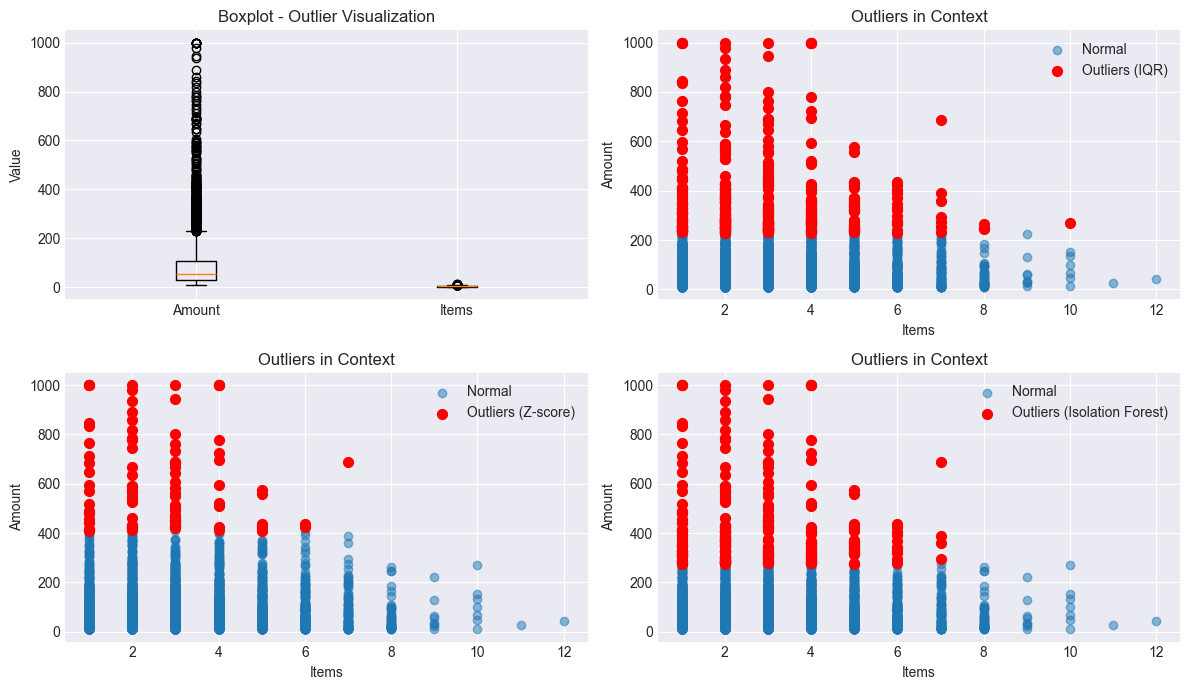

In [7]:
# Visualize outliers
fig, axes = plt.subplots(2, 2, figsize=(12, 7))

# Boxplot
axes[0,0].boxplot([df['amount'], df['items']], labels=['Amount', 'Items'])
axes[0,0].set_title('Boxplot - Outlier Visualization')
axes[0,0].set_ylabel('Value')

# Scatter with outliers highlighted - based on IQR
axes[0,1].scatter(df['items'], df['amount'], alpha=0.5, label='Normal')
axes[0,1].scatter(outliers['IQR']['items'], outliers['IQR']['amount'], 
               color='red', label='Outliers (IQR)', s=50)
axes[0,1].set_xlabel('Items')
axes[0,1].set_ylabel('Amount')
axes[0,1].set_title('Outliers in Context')
axes[0,1].legend()

# Scatter with outliers highlighted - based on Z-score
axes[1,0].scatter(df['items'], df['amount'], alpha=0.5, label='Normal')
axes[1,0].scatter(outliers['Z-score']['items'], outliers['Z-score']['amount'], 
               color='red', label='Outliers (Z-score)', s=50)
axes[1,0].set_xlabel('Items')
axes[1,0].set_ylabel('Amount')
axes[1,0].set_title('Outliers in Context')
axes[1,0].legend()

# Scatter with outliers highlighted - based on Isolation Forest
axes[1,1].scatter(df['items'], df['amount'], alpha=0.5, label='Normal')
axes[1,1].scatter(outliers['Isolation Forest']['items'], outliers['Isolation Forest']['amount'], 
               color='red', label='Outliers (Isolation Forest)', s=50)
axes[1,1].set_xlabel('Items')
axes[1,1].set_ylabel('Amount')
axes[1,1].set_title('Outliers in Context')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## 5. Temporal Patterns and Trends

In [8]:
# Time-based analysis
df['order_month'] = df['order_date'].dt.to_period('M')
df['order_weekday'] = df['order_date'].dt.day_name()
df['order_day'] = df['order_date'].dt.day

# Monthly trends
monthly_stats = df.groupby('order_month').agg({
    'amount': ['sum', 'mean', 'count'],
    'customer_id': 'nunique'
}).round(2)
monthly_stats.columns = ['Total_Revenue', 'Avg_Order', 'Order_Count', 'Unique_Customers']
print("Monthly Performance:")
print(monthly_stats.tail())

# Day of week patterns
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_stats = df.groupby('order_weekday')['amount'].agg(['mean', 'count'])
weekday_stats = weekday_stats.reindex(weekday_order)
print("\nWeekday Patterns:")
print(weekday_stats)

# Customer lifecycle
customer_stats = df.groupby('customer_id').agg({
    'amount': ['sum', 'mean', 'count'],
    'order_date': ['min', 'max']
})
customer_stats.columns = ['Total_Spent', 'Avg_Order', 'Order_Count', 'First_Order', 'Last_Order']
customer_stats['Days_Active'] = (customer_stats['Last_Order'] - customer_stats['First_Order']).dt.days
customer_stats['CLV_Category'] = pd.qcut(customer_stats['Total_Spent'], 
                                          q=4, labels=['Low', 'Medium', 'High', 'VIP'])

print("\nCustomer Lifetime Value Distribution:")
print(customer_stats['CLV_Category'].value_counts())

Monthly Performance:
             Total_Revenue  Avg_Order  Order_Count  Unique_Customers
order_month                                                         
2025-04            3085.80     102.86           30                29
2025-05            2482.75      80.09           31                31
2025-06            2526.83      84.23           30                30
2025-07            3112.87     100.42           31                31
2025-08            2594.30     103.77           25                25

Weekday Patterns:
                mean  count
order_weekday              
Monday         89.07    715
Tuesday        97.60    714
Wednesday      87.65    714
Thursday       86.91    714
Friday         85.35    714
Saturday       86.36    714
Sunday         89.37    715

Customer Lifetime Value Distribution:
CLV_Category
Low       249
Medium    249
VIP       249
High      248
Name: count, dtype: int64


### Exercise 2

**Exercise 2 — Cohort Analysis (hard)**  
Create a cohort analysis showing customer retention by signup month.


In [188]:
# recreate the customer_stats df with reset index:
customer_stats_rev = df.groupby('customer_id').agg({
    'amount': ['sum', 'mean', 'count'],
    'order_date': ['min', 'max']
}).reset_index()
customer_stats_rev.columns = ['customer_id','Total_Spent', 'Avg_Order', 'Order_Count', 'First_Order', 'Last_Order']
customer_stats_rev['Days_Active'] = (customer_stats['Last_Order'] - customer_stats['First_Order']).dt.days

# recreate the 'signup_date' column, as the original version has the signup date more recent than the order date
customer_stats_rev['signup_date'] = pd.date_range(end='2013-12-17', periods=len(customer_stats_rev))

# computing the duration since signup
customer_stats_rev['signup_month']=customer_stats_rev['signup_date'].dt.month
customer_stats_rev['last_order_month']=customer_stats_rev['Last_Order'].dt.month
customer_stats_rev['signup_year']=customer_stats_rev['signup_date'].dt.year
customer_stats_rev['last_order_year']=customer_stats_rev['Last_Order'].dt.year
customer_stats_rev['months_since_signup']=((customer_stats_rev['last_order_year']-customer_stats_rev['signup_year'])*12 
                                           + customer_stats_rev['last_order_month'] - customer_stats_rev['signup_month']).clip(lower=0)

# original signup customer counts, groupby signup month
signup_customers_grouped = (customer_stats_rev.groupby('signup_month')['customer_id'].nunique().reset_index()
    .rename(columns ={'customer_id':'Signup_customer_counts'}))

# active customer counts, groupby signup month
active_customers = customer_stats_rev[(customer_stats_rev['Days_Active']>0) & (customer_stats_rev['months_since_signup']>0)]
active_customers_grouped = (active_customers.groupby('signup_month')['customer_id'].nunique().reset_index()
                           .rename(columns={'customer_id':'Active_customer_counts'}))

# merge the grouped original signup and active customer counts
retention = pd.merge(
    active_customers_grouped,
    signup_customers_grouped,
    on = 'signup_month',
    how='left'
)

# compute the retention rate
retention['retention_rates']=round(retention['Active_customer_counts']/retention['Signup_customer_counts']*100,2)

print("Retention rates of customers, grouped by signup month:")
print(retention)

Retention rates of customers, grouped by signup month:
    signup_month  Active_customer_counts  Signup_customer_counts  \
0              1                      57                      62   
1              2                      56                      57   
2              3                      59                      65   
3              4                      84                      90   
4              5                      85                      93   
5              6                      86                      90   
6              7                      91                      93   
7              8                      92                      93   
8              9                      85                      90   
9             10                      91                      93   
10            11                      87                      90   
11            12                      78                      79   

    retention_rates  
0             91.94  
1             98

<details>
<summary><b>Solution</b></summary>

```python
# Prepare cohort data
df['signup_month'] = pd.to_datetime(customers['signup_date']).dt.to_period('M')
df['order_month_dt'] = df['order_date'].dt.to_period('M')

# Create cohort table
cohort_data = df.groupby(['signup_month', 'order_month_dt']).agg({
    'customer_id': 'nunique'
}).reset_index()

# Calculate periods since signup
cohort_data['period_number'] = (cohort_data['order_month_dt'] - 
                                cohort_data['signup_month']).apply(lambda x: x.n)

# Pivot for cohort table
cohort_pivot = cohort_data.pivot_table(
    index='signup_month',
    columns='period_number',
    values='customer_id'
)

# Calculate retention rates
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0) * 100

print("Cohort Retention Rates (%)")
print(retention.iloc[:5, :5].round(1))  # First 5 cohorts, first 5 periods

# Visualize
plt.figure(figsize=(12, 6))
sns.heatmap(retention.iloc[:10, :10], annot=True, fmt='.0f', 
            cmap='YlOrRd', vmin=0, vmax=100)
plt.title('Customer Retention Cohort Analysis')
plt.xlabel('Periods Since Signup')
plt.ylabel('Signup Cohort')
plt.show()
```
</details>

## 6. Feature Engineering & Derived Insights

In [11]:
# Create meaningful features
df['revenue_per_item'] = df['amount'] / df['items']
df['is_weekend'] = df['order_date'].dt.dayofweek.isin([5, 6])
df['is_high_value'] = df['amount'] > df['amount'].quantile(0.75)

# Customer segmentation features
customer_features = df.groupby('customer_id').agg({
    'amount': ['sum', 'mean', 'std'],
    'items': 'mean',
    'order_id': 'count',
    'category': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
}).round(2)

customer_features.columns = ['Total_Revenue', 'Avg_Order_Value', 'Order_Volatility',
                             'Avg_Items', 'Order_Frequency', 'Favorite_Category']

# RFM Analysis (Recency, Frequency, Monetary)
current_date = df['order_date'].max()
rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (current_date - x.max()).days,  # Recency
    'order_id': 'count',  # Frequency
    'amount': 'sum'  # Monetary
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Create RFM segments
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=['4', '3', '2', '1'])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=['1', '2', '3', '4'])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=4, labels=['1', '2', '3', '4'])
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

print("RFM Segmentation Summary:")
print(rfm.head(10))

# Top segments
print("\nTop Customer Segments:")
print(rfm['RFM_Score'].value_counts().head(10))

RFM Segmentation Summary:
             Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Score
customer_id                                                                
1                260          8   1322.37       4       4       4       444
2                272          5    404.13       4       2       3       423
3                557          3    135.16       3       1       1       311
4                777          5    755.77       2       2       4       224
5               1410          4    485.31       1       2       3       123
6                363          6    356.54       3       3       2       332
7                279          4    466.30       4       2       3       423
8               1553          5    543.56       1       2       3       123
9                155          4    346.30       4       2       2       422
10               504          5    337.91       3       2       2       322

Top Customer Segments:
RFM_Score
111    78
444    54
344    4

## 7. Data Quality & Integrity Checks

In [12]:
# Comprehensive data quality report
def comprehensive_eda_report(df):
    report = {}
    
    # Basic info
    report['shape'] = df.shape
    report['memory_usage'] = df.memory_usage(deep=True).sum() / 1024**2  # MB
    
    # Missing values
    report['missing_values'] = df.isnull().sum().to_dict()
    report['missing_percentage'] = (df.isnull().sum() / len(df) * 100).to_dict()
    
    # Duplicates
    report['duplicate_rows'] = df.duplicated().sum()
    
    # Data types
    report['dtypes'] = df.dtypes.value_counts().to_dict()
    
    # Unique values
    report['unique_counts'] = df.nunique().to_dict()
    
    # Numerical statistics
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        report['numeric_summary'] = df[numeric_cols].describe().to_dict()
    
    # Categorical statistics
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) > 0:
        report['categorical_summary'] = {}
        for col in cat_cols:
            report['categorical_summary'][col] = {
                'unique': df[col].nunique(),
                'most_common': df[col].mode()[0] if len(df[col].mode()) > 0 else None,
                'frequency': df[col].value_counts().iloc[0] if len(df[col].value_counts()) > 0 else 0
            }
    
    return report

eda_report = comprehensive_eda_report(df)

print("=" * 50)
print("COMPREHENSIVE EDA REPORT")
print("=" * 50)
print(f"\nDataset Shape: {eda_report['shape']}")
print(f"Memory Usage: {eda_report['memory_usage']:.2f} MB")
print(f"Duplicate Rows: {eda_report['duplicate_rows']}")
print(f"\nData Types Distribution:")
for dtype, count in eda_report['dtypes'].items():
    print(f"  {dtype}: {count}")

COMPREHENSIVE EDA REPORT

Dataset Shape: (5000, 16)
Memory Usage: 1.42 MB
Duplicate Rows: 0

Data Types Distribution:
  object: 4
  int64: 3
  datetime64[ns]: 2
  float64: 2
  int32: 2
  bool: 2
  period[M]: 1


## 8. Key Insights & Recommendations

In [13]:
# Generate actionable insights
insights = []

# Insight 1: Best performing segment
best_segment = df.groupby('member_type')['amount'].mean().idxmax()
best_value = df.groupby('member_type')['amount'].mean().max()
insights.append(f"1. {best_segment} members have highest avg order value: ${best_value:.2f}")

# Insight 2: Peak shopping day
peak_day = weekday_stats['mean'].idxmax()
insights.append(f"2. {peak_day} has highest average order value")

# Insight 3: Customer concentration
top_10_pct = customer_stats.nlargest(int(len(customer_stats) * 0.1), 'Total_Spent')
revenue_concentration = top_10_pct['Total_Spent'].sum() / customer_stats['Total_Spent'].sum()
insights.append(f"3. Top 10% of customers generate {revenue_concentration:.1%} of revenue")

# Insight 4: Category performance
category_performance = df.groupby('category')['amount'].agg(['mean', 'count', 'sum'])
best_category = category_performance['mean'].idxmax()
insights.append(f"4. {best_category} has highest average order value")

# Insight 5: Growth trend
first_month_revenue = monthly_stats.iloc[0]['Total_Revenue']
last_month_revenue = monthly_stats.iloc[-1]['Total_Revenue']
growth_rate = (last_month_revenue - first_month_revenue) / first_month_revenue
insights.append(f"5. Revenue grew {growth_rate:.1%} from first to last month")

print("📊 KEY INSIGHTS FROM EDA")
print("="*50)
for insight in insights:
    print(insight)

print("\n📈 RECOMMENDED ACTIONS")
print("="*50)
recommendations = [
    "• Focus marketing efforts on converting Basic to Premium members",
    f"• Increase inventory and promotions for {peak_day}s",
    "• Implement VIP loyalty program for top 10% customers",
    f"• Expand {best_category} product line",
    "• Investigate and replicate factors driving growth"
]
for rec in recommendations:
    print(rec)

📊 KEY INSIGHTS FROM EDA
1. Basic members have highest avg order value: $89.57
2. Tuesday has highest average order value
3. Top 10% of customers generate 24.3% of revenue
4. Home has highest average order value
5. Revenue grew 160.2% from first to last month

📈 RECOMMENDED ACTIONS
• Focus marketing efforts on converting Basic to Premium members
• Increase inventory and promotions for Tuesdays
• Implement VIP loyalty program for top 10% customers
• Expand Home product line
• Investigate and replicate factors driving growth


## 9. Mini-Challenges
- **M1 (easy):** Find the customer with highest average order value
- **M2 (medium):** Identify seasonal patterns in the data
- **M3 (hard):** Build a customer scoring system based on multiple factors

In [ ]:
# Your turn - try the challenges!

### M1 (easy): Find the customer with highest average order value

In [30]:
highest_avg_order_customer = customer_stats['Avg_Order'].idxmax()
highest_avg_order = customer_stats['Avg_Order'].max()
print(f"Customer {highest_avg_order_customer} has largest average order at $ {highest_avg_order:.2f}")

Customer 24 has largest average order at $ 378.13


### M2 (medium): Identify seasonal patterns in the data

In [14]:
df['order_month_name']= df['order_date'].dt.month_name()

In [23]:
# Monthly trends
monthly_stats2 = df.groupby('order_month_name').agg({
    'amount': ['sum', 'mean', 'min', 'max', 'count'],
    'customer_id': 'nunique'
}).round(2)
monthly_stats2.columns = ['Total_Revenue', 'Avg_Order', 'Min_Order', 'Max_Order', 'Order_Count', 'Unique_Customers']
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_stats2 = monthly_stats2.reindex(month_order).reset_index()

In [24]:
monthly_stats2

,order_month_name,Total_Revenue,Avg_Order,Min_Order,Max_Order,Order_Count,Unique_Customers
0,January,42006.08,96.79,10.0,1000.00,434,336
1,February,35387.64,89.36,10.0,1000.00,396,321
2,March,36612.27,84.36,10.0,1000.00,434,359
3,April,41385.96,98.54,10.0,1000.00,420,344
4,May,37083.58,85.45,10.0,944.61,434,354
5,June,33509.00,79.78,10.0,746.05,420,324
6,July,37538.27,86.49,10.0,670.04,434,356
7,August,38263.78,89.40,10.0,667.12,428,355
8,September,35934.51,92.14,10.0,978.72,390,319
9,October,32350.72,80.27,10.0,1000.00,403,327


In [49]:
df['season']=df['order_month_name'].apply(lambda x:
                                          'Summer' if x in ['December', 'January', 'February'] else
                                          'Autumn' if x in ['March', 'April', 'May'] else
                                          'Winter' if x in ['June', 'July', 'August'] else 'Spring')

In [59]:
seasonal_stats = df.groupby('season').agg({
    'amount' : ['sum','mean','count'],
    'customer_id' : 'nunique'
}).round(2)
seasonal_stats.columns = ['Total_Revenue', 'Avg_Order', 'Order_Count', 'Unique_Customers']
seasonal_stats = seasonal_stats.reset_index()

In [60]:
seasonal_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   season            4 non-null      object 
 1   Total_Revenue     4 non-null      float64
 2   Avg_Order         4 non-null      float64
 3   Order_Count       4 non-null      int64  
 4   Unique_Customers  4 non-null      int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 292.0+ bytes


In [32]:
#from matplotlib.ticker import FuncFormatter

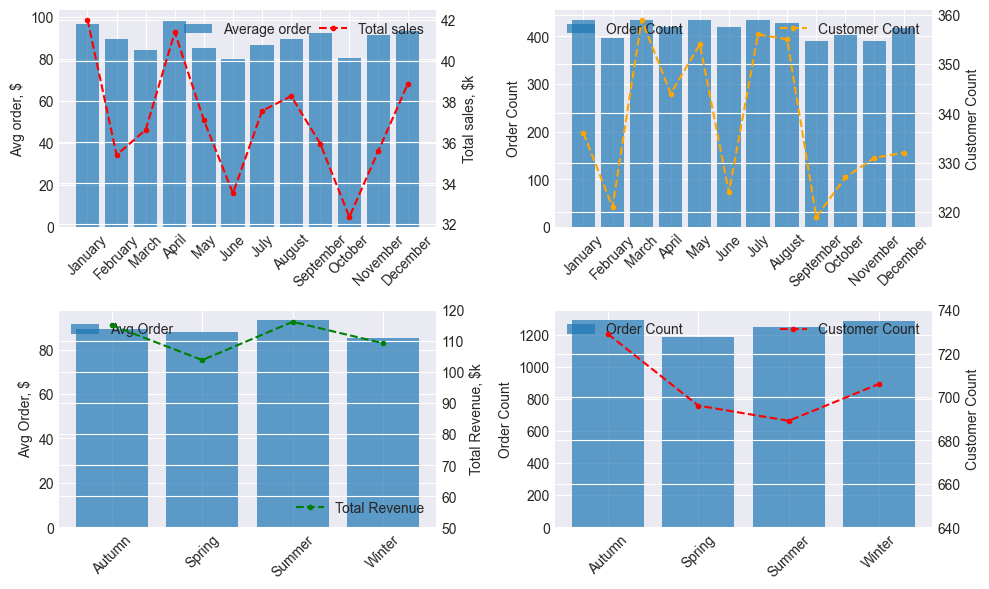

In [74]:
fig, axes = plt.subplots(2,2,figsize = (10,6))
ax1 = axes[0,0]
x = monthly_stats2['order_month_name']
y1 = monthly_stats2['Avg_Order']
y2 = monthly_stats2['Total_Revenue']/1000.0
ax1.bar(x, y1, alpha = 0.7, label = 'Average order')
ax1.set_ylabel('Avg order, $')
ax1.legend(loc = 'upper center')
ax1.tick_params(axis='x', labelrotation = 45)

ax2 = ax1.twinx()
ax2.plot(x, y2, '.', linestyle = '--', label = 'Total sales', color = 'red')
ax2.set_ylabel('Total sales, $k')
ax2.legend()

ax3 = axes[0,1]
y3 = monthly_stats2['Order_Count']
y4 = monthly_stats2['Unique_Customers']
ax3.bar(x, y3, alpha = 0.7, label = 'Order Count')
ax3.set_ylabel('Order Count')
ax3.legend(loc = 'upper left')
ax3.tick_params(axis='x', labelrotation=45)

ax4 = ax3.twinx()
ax4.plot(x,y4, '.', linestyle = '--', label = 'Customer Count', color = 'orange')
ax4.set_ylabel('Customer Count')
ax4.legend(loc = 'upper right')

ax5 = axes[1,0]
x2 = seasonal_stats['season']
y5 = seasonal_stats['Avg_Order']
y6 = seasonal_stats['Total_Revenue']/1000.0
ax5.bar(x2, y5, alpha=0.7, label = 'Avg Order')
ax5.set_ylabel('Avg Order, $')
ax5.legend(loc = 'upper left')
ax5.tick_params(axis='x', labelrotation=45)

ax6 = ax5.twinx()
ax6.plot(x2, y6, '.', linestyle = '--', label = 'Total Revenue', color = 'green')
ax6.set_ylabel('Total Revenue, $k')
ax6.set_ylim(50,120)
ax6.legend(loc = 'lower right')
ax6.tick_params(axis='x', labelrotation = 45)

ax7 = axes[1,1]
y7 = seasonal_stats['Order_Count']
y8 = seasonal_stats['Unique_Customers']
ax7.bar(x2, y7, alpha=0.7, label = 'Order Count')
ax7.set_ylabel('Order Count')
ax7.legend(loc = 'upper left')
ax7.tick_params(axis = 'x', labelrotation = 45)

ax8 = ax7.twinx()
ax8.plot(x2,y8, '.', linestyle = '--', label = 'Customer Count', color = 'red')
ax8.set_ylabel('Customer Count')
ax8.legend(loc = 'upper right')
ax8.set_ylim (640,740)
ax8.tick_params(axis='x', labelrotation = 45)

plt.tight_layout()
plt.show()

### M3 (hard): Build a customer scoring system based on multiple factors

In [77]:
df_copy = pd.merge(orders, customers, on='customer_id')
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   order_id     5000 non-null   int64         
 1   customer_id  5000 non-null   int64         
 2   order_date   5000 non-null   datetime64[ns]
 3   amount       5000 non-null   float64       
 4   items        5000 non-null   int32         
 5   category     5000 non-null   object        
 6   age          5000 non-null   int64         
 7   city         5000 non-null   object        
 8   member_type  5000 non-null   object        
 9   signup_date  5000 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int32(1), int64(3), object(3)
memory usage: 371.2+ KB


In [116]:
def customer_score(df):
    df = df.copy()
    recent_overall_order = df['order_date'].max()
    
    rfm = df.groupby('customer_id').agg({
        'order_date': lambda x: (recent_overall_order-x.max()).days,
        'order_id' : 'count',
        'amount' : 'sum'                                    
    })
    rfm.columns = ['Recency,days','Frequency','Monetary, $']

    rfm['R_Score']=pd.qcut(rfm['Recency,days'], q=4, labels=['4','3','2','1'])
    rfm['F_Score']=pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels = ['1','2','3','4'])
    rfm['M_Score']=pd.qcut(rfm['Monetary, $'], q=4, labels=['1','2','3','4'])
    rfm['RFM_Score']=rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
    rfm['Total_Score']=rfm['R_Score'].astype(int)+rfm['F_Score'].astype(int)+rfm['M_Score'].astype(int)
    
    top_score = rfm['Total_Score'].value_counts().head(12).reset_index(name='Customer_Count').sort_values('Total_Score', ascending=False)

    print(f"RFM Customer Scoring (first 5 rows) : \n{rfm.head()}")
    print(f"\nTop Score Customers: \n{top_score}")    
    

In [118]:
customer_score(df_copy)

RFM Customer Scoring (first 5 rows) : 
             Recency,days  Frequency  Monetary, $ R_Score F_Score M_Score  \
customer_id                                                                 
1                     260          8      1322.37       4       4       4   
2                     272          5       404.13       4       2       3   
3                     557          3       135.16       3       1       1   
4                     777          5       755.77       2       2       4   
5                    1410          4       485.31       1       2       3   

            RFM_Score  Total_Score  
customer_id                         
1                 444           12  
2                 423            9  
3                 311            5  
4                 224            8  
5                 123            6  

Top Score Customers: 
   Total_Score  Customer_Count
9           12              54
5           11              96
3           10             112
1            9 

<details>
<summary><b>Solutions</b></summary>

```python
# M1 - Top customer by average order
customer_avg = df.groupby('customer_id')['amount'].mean().sort_values(ascending=False)
top_customer = customer_avg.index[0]
print(f"Customer {top_customer} has highest avg order: ${customer_avg.iloc[0]:.2f}")

# M2 - Seasonal patterns
df['month'] = df['order_date'].dt.month
df['season'] = df['month'].apply(lambda x: 
    'Summer' if x in [12, 1, 2] else
    'Autumn' if x in [3, 4, 5] else
    'Winter' if x in [6, 7, 8] else 'Spring')

seasonal_analysis = df.groupby('season')['amount'].agg(['mean', 'sum', 'count'])
print("\nSeasonal Patterns:")
print(seasonal_analysis)

# M3 - Customer scoring
def customer_score(row):
    score = 0
    # Recency (lower is better)
    if row['Recency'] <= 30: score += 30
    elif row['Recency'] <= 60: score += 20
    elif row['Recency'] <= 90: score += 10
    
    # Frequency
    if row['Frequency'] >= 10: score += 30
    elif row['Frequency'] >= 5: score += 20
    elif row['Frequency'] >= 2: score += 10
    
    # Monetary
    if row['Monetary'] >= 1000: score += 40
    elif row['Monetary'] >= 500: score += 25
    elif row['Monetary'] >= 200: score += 15
    
    return score

rfm['Customer_Score'] = rfm.apply(customer_score, axis=1)
rfm['Customer_Grade'] = pd.cut(rfm['Customer_Score'], 
                               bins=[0, 30, 60, 90, 100],
                               labels=['D', 'C', 'B', 'A'])

print("\nCustomer Scoring Distribution:")
print(rfm['Customer_Grade'].value_counts())
print("\nTop 5 Customers by Score:")
print(rfm.nlargest(5, 'Customer_Score')[['Customer_Score', 'Customer_Grade']])
```
</details>

## Wrap-Up & Next Steps
✅ You've completed a comprehensive EDA workflow  
✅ You can identify patterns, outliers, and relationships  
✅ You generated actionable business insights  
✅ You're ready to visualize these findings beautifully  

**Week 2 Preview:** Transform these insights into interactive dashboards and compelling visualizations!

**Assignment:** Apply this EDA workflow to your own dataset and create a report with 5 key insights.
